# MP Expenses Project
by Darren Christie 
Created May 2020

This is a project notebook that looks at MP Expenses.
The notebook compares a single MP (which will probably be your local MP) with the expenses of all MPs.

## The Data
Data has been obtained from the [IPSA website](https://www.theipsa.org.uk/mp-costs/annual-publication/) starting from 2010/2011 csv files were downloaded for individual claims for each reported year. The datasets were downloaded 6/6/2020.

The following awk command was used to merge the individual csv files into a combined csv file with a single header.

`awk '(NR == 1) || (FNR > 1)' Individual*.csv > combined_claims.csv`

FNR represents the number of the processed record in a single file. NR represents it globally. Therefore the first line is accepted and the rest are ignored.
I can not take credit for the above awk command. I got it from the StackExchange website (accessed on 14/5/2020) and was an answer provided by a Marek Grac.

The resulting csv file just shy of 340MB. Too large to read in to Jupyter. So this csv file was imported into an sqlite3 database.

In [791]:
# our standard import for our projects
from pandas import *
import matplotlib.pyplot as plot

In [792]:
# tells Jupyter to display all charts inside this notebook, immediately after each call to plot()
%matplotlib inline

In [793]:
# read in our data file of MP Expenses
mpIndExp = read_csv('data/processed/combined_claims.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (2,20) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Clean up data

In [794]:
# remove apostrophe from column names
mpIndExp.columns = mpIndExp.columns.str.replace("'","")

In [795]:
# correct NaN by replacing with a sensible default value
mpIndExp['Short Description'] = mpIndExp['Short Description'].fillna('')
mpIndExp['Details'] = mpIndExp['Details'].fillna('')
mpIndExp['Journey Type'] = mpIndExp['Journey Type'].fillna('')
mpIndExp['Nights'] = mpIndExp['Nights'].fillna(0.0)
mpIndExp['Mileage'] = mpIndExp['Mileage'].fillna(0.0)
mpIndExp['Reason If Not Paid'] = mpIndExp['Reason If Not Paid'].fillna('')
# mpIndExp[mpIndExp['Reason If Not Paid'].isnull()]

In [796]:
# drop the Year column
# this column seems redundant considering that we have a date column as well
mpIndExp = mpIndExp.drop('Year', 1)

In [797]:
# correct column types
mpIndExp['Date'] = to_datetime(mpIndExp['Date'])
#mpIndExp['From'] = to_datetime(mpIndExp['From'])
#mpIndExp['To'] = to_datetime(mpIndExp['To'])

In [798]:
# remove empty last row
mpIndExp = mpIndExp.dropna(subset=['Date'])

In [799]:
# set the Date column to our index
mpIndExp.index = mpIndExp['Date']
mpIndExp = mpIndExp.sort_index()

## Assumptions about the data
* that the MPs expenses year follows a tax year and runs from 1st May - 30th April.
* that -ve values in the Amount Paid and Claimed columns means that the MP has had to pay money back. This is current a query I have raised with the IPSA via social media to confirm one way or the other.

The MP that we are interested in investigating their expenses.
If you are unsure who your MP is you can find out at [FindYourMP](https://members.parliament.uk/FindYourMP). Enter your post code and it will tell you who you MP is.
**NOTE:** The name of your MP needs to match exactly as it appears in the csv file/dataframe. Otherwise it will not find anything.

In [800]:
localMP = "Stephen Barclay"

Creating a small list to store some stats in from the built in functions for Pandas that will later be used to 
create a dataframe for processing.

In [801]:
# These next two lines of code basically remove -ve values, which I have assumed means that the MP has repaid money 
# to the IPSA.
temp1DF = mpIndExp[mpIndExp['Amount Paid'] >= 0]
amountPaid = temp1DF['Amount Paid']
#create a list to hold the measures of 'average' for all the MPs
data = [[amountPaid.mean(),amountPaid.median(),amountPaid.sum(),amountPaid.max(),amountPaid.min(),(amountPaid.max() - amountPaid.min())]]

This next bit creates a dataframe that consists just of the local MP's expenses

In [802]:
localMPExpenses = mpIndExp[mpIndExp['MPs Name'] == localMP]
localMPExpenses = localMPExpenses.sort_index()

In [803]:
localMPExpenses

,Date,Claim No.,MPs Name,MPs Constituency,Category,Expense Type,Short Description,Details,Journey Type,From,...,Nights,Mileage,Amount Claimed,Amount Paid,Amount Not Paid,Amount Repaid,Status,Reason If Not Paid,Supply Month,Supply Period
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-09,2010-01-09,27850,Stephen Barclay,North East Cambridgeshire CC,Accommodation,Accommodation Rent,Rent [***] Oct 2010,Rent [***],,NaN,...,0.0,0.0,1450.00,1450.00,0.0,0.0,Paid,,0,0
2010-01-09,2010-01-09,27847,Stephen Barclay,North East Cambridgeshire CC,Miscellaneous Expenses,Contingency,Top-up rent October 2010,Top-up rent before baby born,,NaN,...,0.0,0.0,204.16,204.16,0.0,0.0,Paid,,0,0
2010-01-09,2010-01-09,32683,Stephen Barclay,North East Cambridgeshire CC,MP Travel,Own Car MP,,,London Home to Const Home,NaN,...,0.0,0.0,36.48,36.48,0.0,0.0,Paid,,0,0
2010-01-09,2010-01-09,32683,Stephen Barclay,North East Cambridgeshire CC,MP Travel,Own Car MP,,,Const Office to Westminster,NaN,...,0.0,0.0,39.28,39.28,0.0,0.0,Paid,,0,0
2010-01-09,2010-01-09,32683,Stephen Barclay,North East Cambridgeshire CC,MP Travel,Own Car MP,,,Travel within Constituency,NaN,...,0.0,0.0,3.08,3.08,0.0,0.0,Paid,,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-03,2019-12-03,718073,Stephen Barclay,North East Cambridgeshire CC,Staffing,Own Vehicle Car Volunteer,,,Volunteer Travel,NaN,...,0.0,0.0,4.86,4.86,0.0,0.0,Paid,,0,0
2019-12-03,2019-12-03,718073,Stephen Barclay,North East Cambridgeshire CC,Staffing,Own Vehicle Car Volunteer,,,Volunteer Travel,NaN,...,0.0,0.0,4.86,4.86,0.0,0.0,Paid,,0,0
2019-12-08,2019-12-08,60018109-9,Stephen Barclay,North East Cambridgeshire CC,Office Costs,Stationery & printing,,AMZNMKTPLACE,,NaN,...,0.0,0.0,22.50,22.50,0.0,0.0,Paid,,0,0


In [804]:
localMPExpenses.Category.unique()

array(['Accommodation', 'Miscellaneous Expenses', 'MP Travel',
       'Office Costs', 'Staff Travel', 'Staffing', 'Dependant Travel',
       'Office Costs Expenditure'], dtype=object)

In [805]:
localMPExpenses['Expense Type'].unique()

array(['Accommodation Rent', 'Contingency', 'Own Car MP',
       'Computer SW Purchase', 'Const Office Hire of Premises',
       'Const Office Rent', 'Own Car MP Staff', 'Public Tr RAIL - SGL',
       'Public Tr RAIL - RTN', 'Stationery Purchase',
       'Contents Insurance', 'Const Office Tel. Usage/Rental',
       'Business Rates', 'Office Furniture Purchase', 'Venue Hire',
       'Pooled Staffing Services', 'Computer HW Purchase',
       'Scanner Purchase', 'Payment Telephone/Mobile',
       'Telephone/Mobile Hire', 'Removal Costs', 'Water',
       'Telephone Usage/Rental', 'Gas', 'Television Licence',
       'Telephone/Mobile Purchase', 'Shredder Purchase', 'Advertising',
       'Electricity', 'Public Tr RAIL MP Staff - RTN',
       'Mobile Usage/Rental', 'Own Car Dependant', 'Council Tax',
       'Professional Services', 'Website - Design/Production', 'Payroll',
       'Hospitality', 'Parking MP Staff', 'Other', 'Contact Cards',
       'Public Tr RAIL Other MP Staff', 'Shredder Hi

In [806]:
# These next two lines of code basically remove -ve values, which I have assumed means that the MP has repaid money 
# to the IPSA.
temp1DF = localMPExpenses[localMPExpenses['Amount Paid'] >= 0]
localMPAmountPaid = temp1DF['Amount Paid']

In [807]:
# add the measures of average for the local MP to the list that is holding the results for everyone
data.append([localMPAmountPaid.mean(),localMPAmountPaid.median(),localMPAmountPaid.sum(),localMPAmountPaid.max(),localMPAmountPaid.min(),(localMPAmountPaid.max() - localMPAmountPaid.min())])

In [808]:
# turn that list into a dataframe so that we can start using some of the Pandas goodies on the data
mpStats = DataFrame(data,columns = ['Mean','Median','Sum','Max','Min','Range'], index = ['All',localMP])

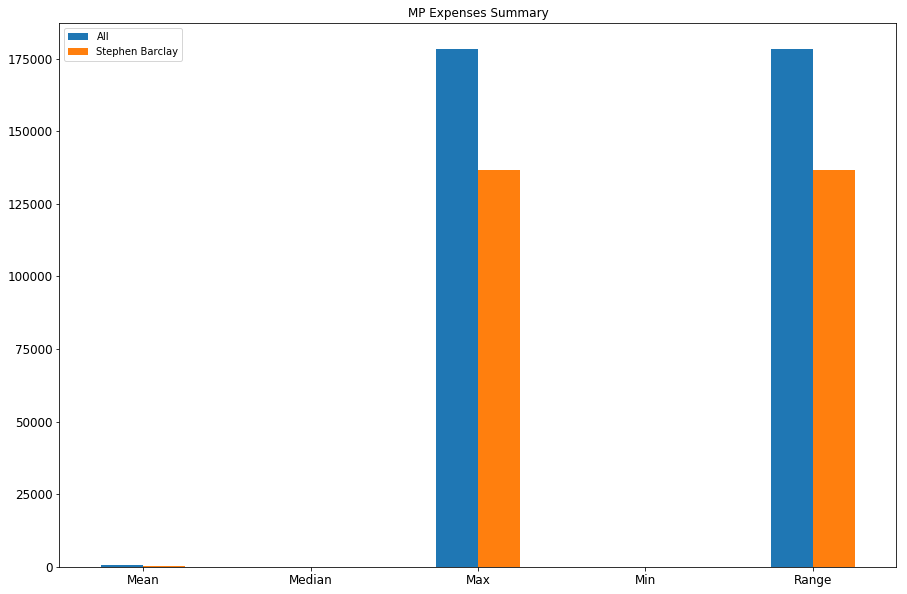

In [809]:
mpStats[['Mean','Median','Max','Min','Range']].T.plot.bar(title='MP Expenses Summary', figsize=(15
                                                                                                ,10),legend=True, fontsize=12, rot=0)


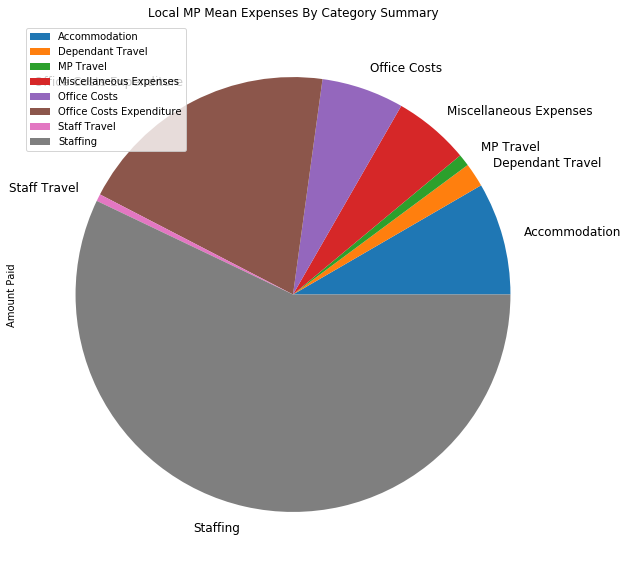

In [810]:
# group by category
group = temp1DF['Amount Paid'].groupby(temp1DF['Category'])
group.mean().plot.pie(title='Local MP Mean Expenses By Category Summary', figsize=(15,10),legend=True, fontsize=12)
#group.median().plot.bar()

Creating some yearly summary stats for the MP

In [811]:
startYear = 2010
currYear = startYear
endYear = 2020

In [812]:
# a list to hold the yearly summary stats before turning into a dataframe
mpYearlyData = []
mpYearlyDataIndex = []
# dataframes to hold our summary stats
mpTopLevelStatsMean = DataFrame()
mpTopLevelStatsMedian = DataFrame()
mpTopLevelStatsMax = DataFrame()
mpTopLevelStatsMin = DataFrame()
mpTopLevelStatsRange = DataFrame()
mpDetailedLevelGroups = DataFrame()

In [813]:
tempDF = localMPExpenses.loc[datetime(2010,5,1):datetime(2020,4,30)]
tempDF1 = tempDF[tempDF['Amount Paid'] >= 0]
tempAmountPaid = tempDF1['Amount Paid']
expensesGroups = tempDF1['Amount Paid'].groupby(tempDF1['Category'])
expensesGroups.groups.keys()
# create a column that contains the unique categories claimed for by the MP and set this column as an index
mpTopLevelStatsMean['Category'] = expensesGroups.groups.keys()
mpTopLevelStatsMean.set_index('Category', inplace = True)
mpTopLevelStatsMedian['Category'] = expensesGroups.groups.keys()
mpTopLevelStatsMedian.set_index('Category', inplace = True)
mpTopLevelStatsMax['Category'] = expensesGroups.groups.keys()
mpTopLevelStatsMax.set_index('Category', inplace = True)
mpTopLevelStatsMin['Category'] = expensesGroups.groups.keys()
mpTopLevelStatsMin.set_index('Category', inplace = True)
mpTopLevelStatsRange['Category'] = expensesGroups.groups.keys()
mpTopLevelStatsRange.set_index('Category', inplace = True)

This next bit loops round extracting each years stats.
A year runs from 1st May - 30th April which follows a tax year.

In [814]:
for counter in range (0,(endYear - startYear)):
    tempIndex = str(currYear)+'/'+str(currYear+1)
    # get the data for the current tax year
    tempDF = localMPExpenses.loc[datetime(currYear,5,1):datetime(currYear+1,4,30)]
    # These next two lines of code basically remove -ve values, which I have assumed means that the MP has repaid money 
    # to the IPSA.
    tempDF1 = tempDF[tempDF['Amount Paid'] >= 0]
    tempAmountPaid = tempDF1['Amount Paid']
    # collect group data by Category then by Expense Type
    expensesGroups = tempDF1['Amount Paid'].groupby(tempDF1['Category'])
    mpTopLevelStatsMean[tempIndex] = expensesGroups.mean()
    mpTopLevelStatsMedian[tempIndex] = expensesGroups.median()
    mpTopLevelStatsMax[tempIndex] = expensesGroups.max()
    mpTopLevelStatsMin[tempIndex] = expensesGroups.min()
    mpTopLevelStatsRange[tempIndex] = (expensesGroups.max()-expensesGroups.min())
    # add a column for the tax year to the top level
    #mpTopLevelStatsMean[tempIndex] = [topLevelGroups.mean()]
    # collect group data by Category then by Expense Type
    #expensesGroups = tempDF1['Amount Paid'].groupby([tempDF1['Category'],tempDF1['Expense Type']])
    # build up our stats
    mpYearlyData.append([tempAmountPaid.mean(),tempAmountPaid.median(),tempAmountPaid.sum(),tempAmountPaid.max(),tempAmountPaid.min(),(tempAmountPaid.max() - tempAmountPaid.min())])
    mpYearlyDataIndex.append(tempIndex)
    currYear += 1

In [815]:
mpYearlyStats = DataFrame(mpYearlyData,columns = ['Mean','Median','Sum','Max','Min','Range'], index = mpYearlyDataIndex)
mpYearlyStats

,Mean,Median,Sum,Max,Min,Range
2010/2011,425.899190,36.72,120955.37,76618.58,1.24,76617.34
2011/2012,591.080906,41.31,163138.33,112349.62,3.00,112346.62
2012/2013,726.078545,42.40,154654.73,106964.23,0.00,106964.23
2013/2014,460.562781,35.11,155670.22,106133.41,0.00,106133.41
2014/2015,578.313764,50.00,156723.03,111326.12,0.00,111326.12
2015/2016,276.103872,35.90,129768.82,88661.02,3.00,88658.02
2016/2017,310.809593,33.20,183377.66,131756.40,0.00,131756.40
2017/2018,268.659829,12.51,188599.20,136664.20,0.36,136663.84
2018/2019,259.109785,12.51,168680.47,111691.89,0.27,111691.62
2019/2020,62.035600,12.60,13958.01,760.50,1.00,759.50


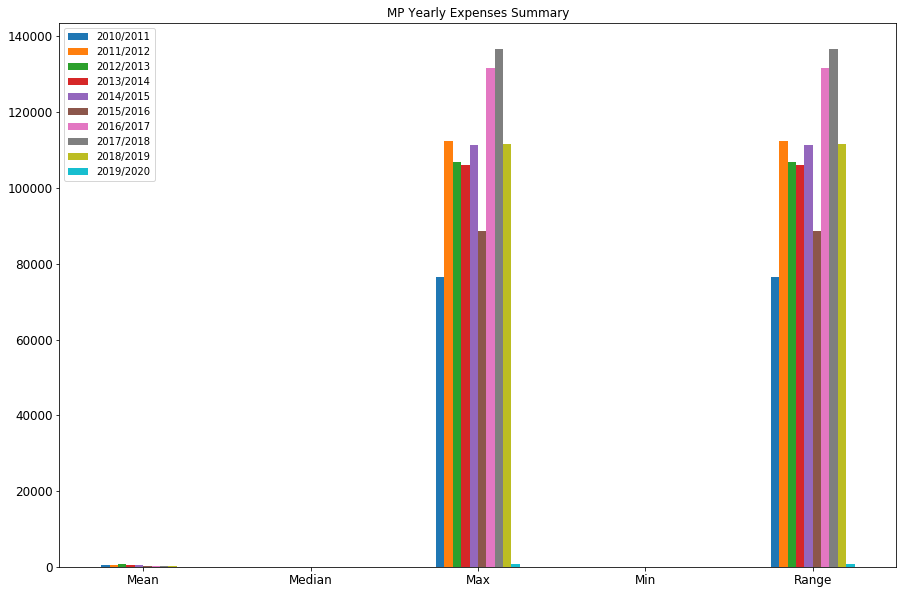

In [816]:
mpYearlyStats[['Mean','Median','Max','Min','Range']].T.plot.bar(title='MP Yearly Expenses Summary', figsize=(15,10),legend=True, fontsize=12, rot=0)

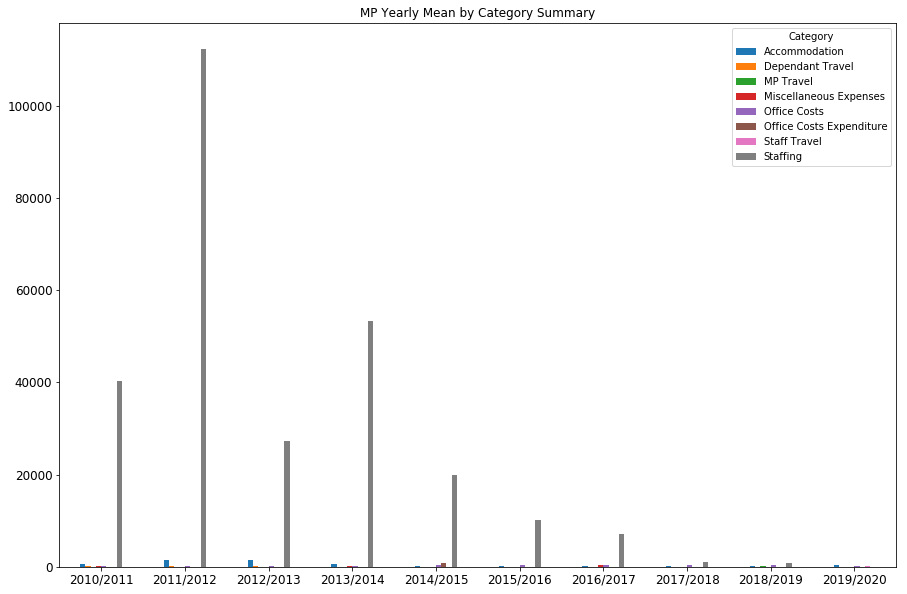

In [817]:
# replace any NaN with a zero
mpTopLevelStatsMean = mpTopLevelStatsMean.fillna(0.0)
# plot our graph
mpTopLevelStatsMean.T.plot.bar(title='MP Yearly Mean by Category Summary', figsize=(15,10),legend=True, fontsize=12, rot=0)

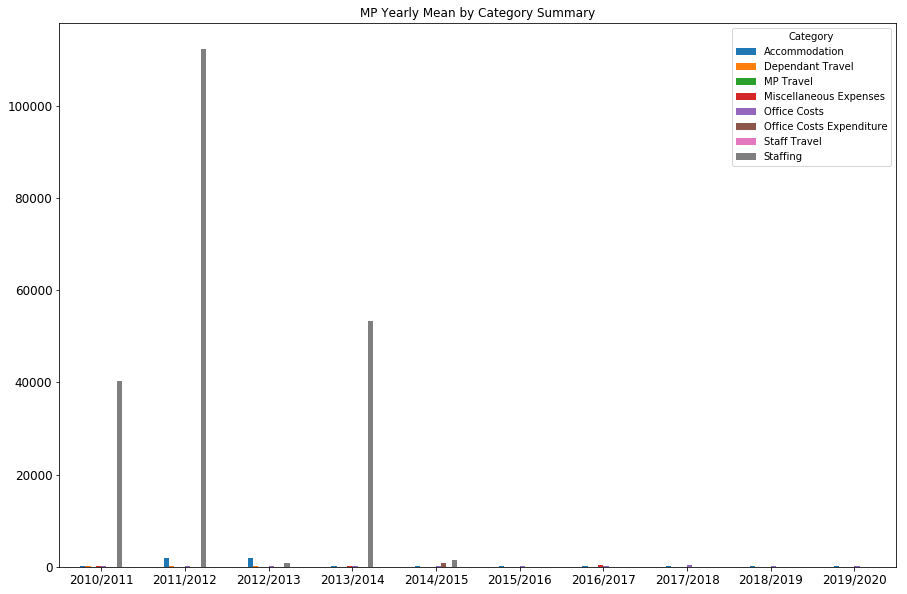

In [818]:
# replace any NaN with a zero
mpTopLevelStatsMedian = mpTopLevelStatsMedian.fillna(0.0)
# plot our graph
mpTopLevelStatsMedian.T.plot.bar(title='MP Yearly Mean by Category Summary', figsize=(15,10),legend=True, fontsize=12, rot=0)

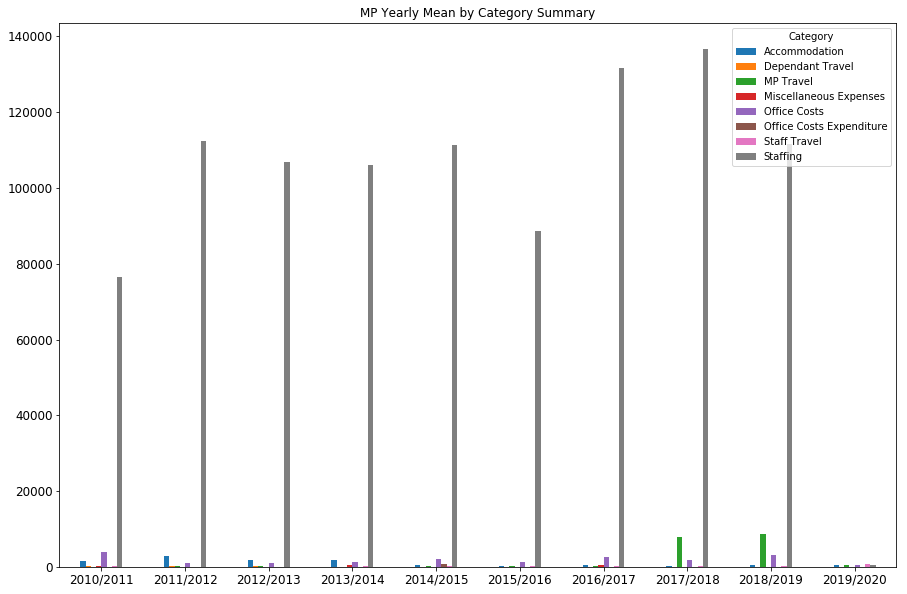

In [819]:
# replace any NaN with a zero
mpTopLevelStatsMax = mpTopLevelStatsMax.fillna(0.0)
# plot our graph
mpTopLevelStatsMax.T.plot.bar(title='MP Yearly Mean by Category Summary', figsize=(15,10),legend=True, fontsize=12, rot=0)

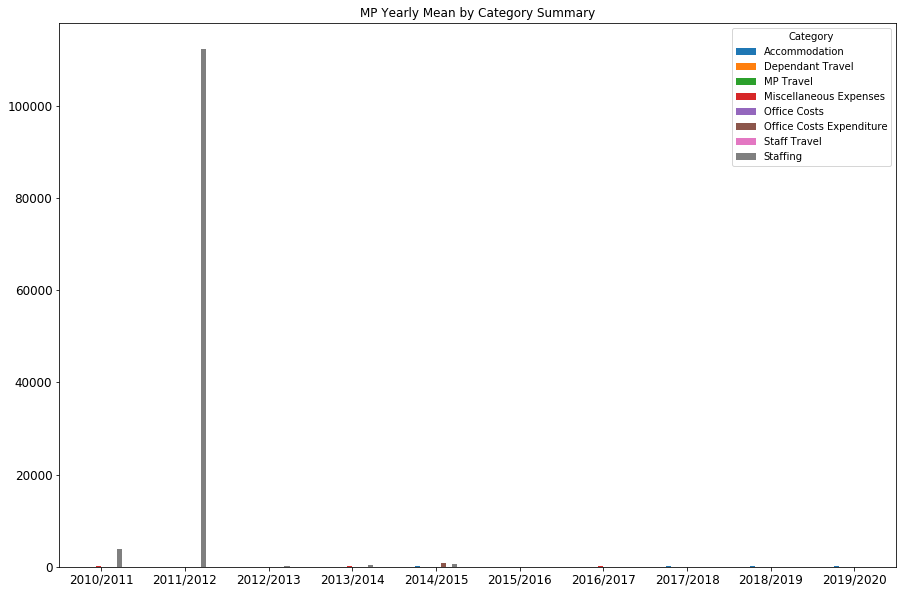

In [820]:
# replace any NaN with a zero
mpTopLevelStatsMin = mpTopLevelStatsMin.fillna(0.0)
# plot our graph
mpTopLevelStatsMin.T.plot.bar(title='MP Yearly Mean by Category Summary', figsize=(15,10),legend=True, fontsize=12, rot=0)

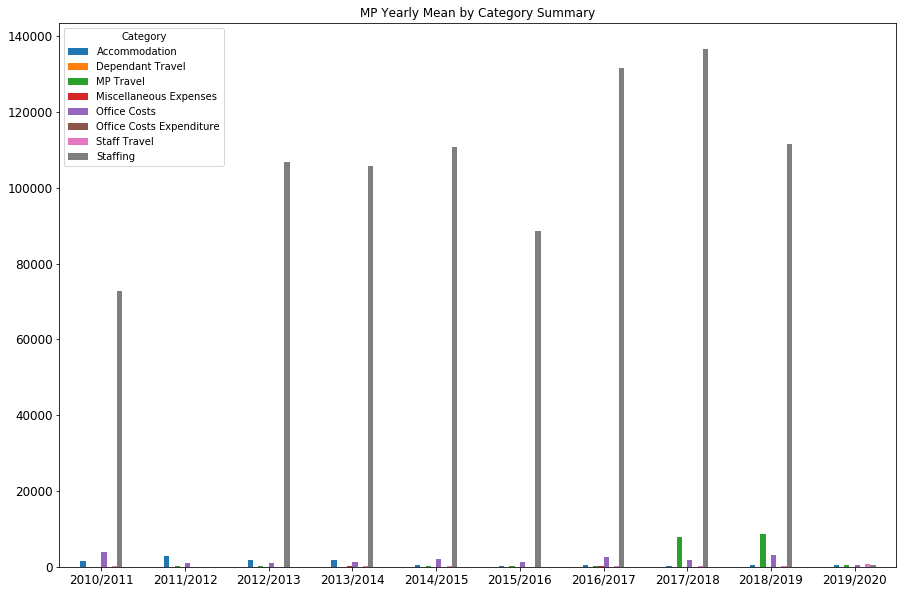

In [821]:
# replace any NaN with a zero
mpTopLevelStatsRange = mpTopLevelStatsRange.fillna(0.0)
# plot our graph
mpTopLevelStatsRange.T.plot.bar(title='MP Yearly Mean by Category Summary', figsize=(15,10),legend=True, fontsize=12, rot=0)